# Bernoulli Toy Experiment

This notebook reproduces the Bernoulli toy experiment in our paper "Estimating Gradients for Discrete Random Variables by Sampling without Replacement". This is a reproduction of the experiment in https://arxiv.org/abs/1810.04777 and the code is adapted from https://github.com/Runjing-Liu120/RaoBlackwellizedSGD/blob/master/experiments/bernoulli_experiments/bernoulli_variances_experiments.ipynb.

In [6]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn
import torch.optim as optim 

from copy import deepcopy

import bernoulli_experiments_lib as bern_lib

import os
import sys

import optimization_lib as optim_lib
import baselines_lib as bs_lib

os.makedirs('plots', exist_ok=True)

In [7]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [8]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [9]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([0.6000, 0.5100, 0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 

optimal loss:  tensor(0.6705)
optimal x:  1


In [10]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))

init phi0:  tensor([0.], requires_grad=True)
init e_b:  tensor([0.5000], grad_fn=<SigmoidBackward>)


# True gradient

In [11]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))
params = [phi0]
optimizer = optim.SGD(params, lr = 1.0)
bern_experiment = bern_lib.BernoulliExperiments(p0, d, phi0)
bern_experiment.set_var_params(deepcopy(phi0))
optimizer.zero_grad()
full_loss = bern_experiment.get_full_loss()
full_loss.backward()
true_grad = deepcopy(bern_experiment.var_params['phi'].grad)
print(true_grad)

init phi0:  tensor([0.], requires_grad=True)
init e_b:  tensor([0.5000], grad_fn=<SigmoidBackward>)
tensor([-0.0450])


# Different estimators

Here we examine the variance of different estimators.  

In [12]:
print(phi0)

tensor([0.], requires_grad=True)


In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
n_samples = 1000

def get_gradient_estimators(phi0):
    phi0.requires_grad_(True)
    params = [phi0]
    bern_experiment = bern_lib.BernoulliExperiments(p0, d, phi0)
    bern_experiment.set_var_params(deepcopy(phi0))
    optbl = bern_experiment.get_full_loss().item()

    def get_grad_unordered(k, baseline_constant=None):
        return bern_lib.sample_bern_gradient(
            phi0, bern_experiment, 
            topk = 0, 
            grad_estimator = bs_lib.reinforce_unordered,
            n_samples = n_samples,
            grad_estimator_kwargs = {
                'n_samples': k,
                'baseline_constant': baseline_constant
            })

    def get_grad_unordered_optbl(k):
        return get_grad_unordered(k, baseline_constant=optbl)

    def get_grad_unordered_nobl(k):
        return get_grad_unordered(k, baseline_constant=0.0)
    
    def get_grad_reinforce_wr(k, baseline_constant=None):
        return bern_lib.sample_bern_gradient(
            phi0, bern_experiment, 
            topk = 0, 
            grad_estimator = bs_lib.reinforce_wr,
            n_samples = n_samples,
            grad_estimator_kwargs = {
                'n_samples': k,
                'baseline_constant': baseline_constant
            })
    
    def get_grad_reinforce_wr_optbl(k):
        return get_grad_reinforce_wr(k, baseline_constant=optbl)
    
    def get_grad_reinforce_wr_nobl(k):
        return get_grad_reinforce_wr(k, baseline_constant=0.0)

    def get_grad_topk(k, sample_topk=False):
        return bern_lib.sample_bern_gradient(
            phi0, bern_experiment, 
            topk = k - 1, 
            sample_topk = sample_topk,
            grad_estimator = bs_lib.reinforce,
            n_samples = n_samples,
            grad_estimator_kwargs={'grad_estimator_kwargs': None})

    def get_grad_topk_bl(k, sample_topk=False):
        return bern_lib.sample_bern_gradient(
            phi0, bern_experiment, 
            topk = k - 1, 
            sample_topk = sample_topk,
            grad_estimator = bs_lib.reinforce_w_double_sample_baseline,
            n_samples = n_samples,
            grad_estimator_kwargs={'grad_estimator_kwargs': None})

    def get_grad_topk_optbl(k, sample_topk=False):
        return bern_lib.sample_bern_gradient(
            phi0, bern_experiment, 
            topk = k - 1, 
            grad_estimator = bs_lib.reinforce,
            n_samples = n_samples,
            grad_estimator_kwargs={'grad_estimator_kwargs': None, 'baseline': optbl})

    def get_grad_topk_sample(k):
        return get_grad_topk(k, sample_topk=True)

    def get_grad_topk_bl_sample(k):
        return get_grad_topk_bl(k, sample_topk=True)

    def get_grad_topk_optbl_sample(k):
        return get_grad_topk_optbl(k, sample_topk=True)

    alpha = 0.2

    xrng = np.arange(2 ** d) + 1
    n_eval = xrng
    n_eval_double = 2 * xrng
    n_eval_optbl = xrng + 2 ** d # Need all evaluations for baseline
    
    c_vimco = colors[1]
    c_detsas = colors[2]
    c_stochsas = colors[3]
    c_unord = colors[0]
    
    estimators = [
        
        (get_grad_reinforce_wr_nobl, "VIMCO (no bl)", n_eval, {'color': c_vimco, 'linestyle': '--', 'marker': '.'}),
        (get_grad_topk, "Det. sum & sample (no bl)", n_eval, {'color': c_detsas, 'linestyle': '--', 'marker': '.'}),
        (get_grad_topk_sample, "Stoch. sum & sample (no bl)", n_eval, {'color': c_stochsas, 'linestyle': '--', 'marker': '.'}),
        (get_grad_unordered_nobl, "Unordered (no bl)", n_eval, {'color': c_unord, 'linestyle': '--', 'marker': '.'}),
        
        (get_grad_reinforce_wr, "VIMCO (built-in bl)", n_eval, {'color': c_vimco, 'linestyle': '-', 'marker': '.'}),
        (get_grad_topk_bl, "Det. sum & sample (sample bl)", n_eval_double, {'color': c_detsas, 'linestyle': '-', 'marker': '.'}),
        (get_grad_topk_bl_sample, "Stoch. sum & sample (sample bl)", n_eval_double, {'color': c_stochsas, 'linestyle': '-', 'marker': '.'}),
        (get_grad_unordered, "Unordered (built-in bl)", n_eval, {'color': c_unord, 'linestyle': '-', 'marker': '.'}),
        
        # Include these to also show result with 'optimal' baseline
#         (get_grad_reinforce_wr_optbl, "VIMCO (mean bl)", n_eval_optbl, {'color': c_vimco, 'linestyle': '-', 'marker': '.', 'alpha': alpha}),
#         (get_grad_topk_optbl, "Det. sum & sample (mean bl)", n_eval_optbl, {'color': c_detsas, 'linestyle': '-', 'marker': '.', 'alpha': alpha}),
#         (get_grad_topk_optbl_sample, "Stoch. sum & sample (mean bl)", n_eval_optbl, {'color': c_stochsas, 'linestyle': '-', 'marker': '.', 'alpha': alpha}),
#         (get_grad_unordered_optbl, "Unordered (mean bl)", n_eval_optbl, {'color': c_unord, 'linestyle': '-', 'marker': '.', 'alpha': alpha}),
        
    ]
    return estimators

# run for low entropy and high entropy setting
phi0 = torch.Tensor([0.0])
phi0_hard = torch.Tensor([-4.0])
estimators = get_gradient_estimators(phi0)
estimators_hard = get_gradient_estimators(phi0_hard)

In [16]:
def run_experiments(estimators, n_samples):
    mixed_grad_array_all = torch.zeros(len(estimators), (2**d), n_samples)

    for i in range(2**d):
        k = i + 1
        print(f"k = {k}")

        for j, (estimator, name, n_ev, plot_kwargs) in enumerate(estimators):
            print(name)
            try:
                grads = estimator(k)
                mixed_grad_array_all[j, i] = grads
            except:
                raise
                print(f"Warn: {name} with {k} evaluations failed")
    return mixed_grad_array_all
mixed_grad_array_all = run_experiments(estimators, n_samples)
mixed_grad_array_all_hard = run_experiments(estimators_hard, n_samples)

k = 1
VIMCO (no bl)
Det. sum & sample (no bl)
Stoch. sum & sample (no bl)
Unordered (no bl)
VIMCO (built-in bl)
Det. sum & sample (sample bl)
Stoch. sum & sample (sample bl)
Unordered (built-in bl)
k = 2
VIMCO (no bl)
Det. sum & sample (no bl)
Stoch. sum & sample (no bl)
Unordered (no bl)
VIMCO (built-in bl)
Det. sum & sample (sample bl)
Stoch. sum & sample (sample bl)
Unordered (built-in bl)
k = 3
VIMCO (no bl)
Det. sum & sample (no bl)
Stoch. sum & sample (no bl)
Unordered (no bl)
VIMCO (built-in bl)
Det. sum & sample (sample bl)
Stoch. sum & sample (sample bl)
Unordered (built-in bl)
k = 4
VIMCO (no bl)
Det. sum & sample (no bl)
Stoch. sum & sample (no bl)
Unordered (no bl)
VIMCO (built-in bl)
Det. sum & sample (sample bl)
Stoch. sum & sample (sample bl)
Unordered (built-in bl)
k = 5
VIMCO (no bl)
Det. sum & sample (no bl)
Stoch. sum & sample (no bl)
Unordered (no bl)
VIMCO (built-in bl)
Det. sum & sample (sample bl)
Stoch. sum & sample (sample bl)
Unordered (built-in bl)
k = 6
VIMC

/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


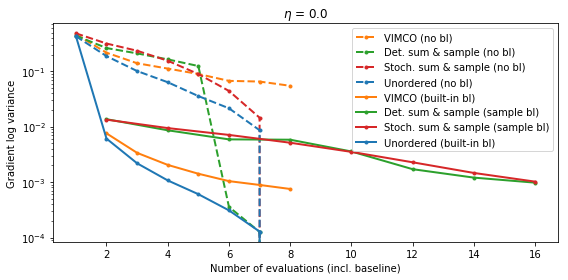

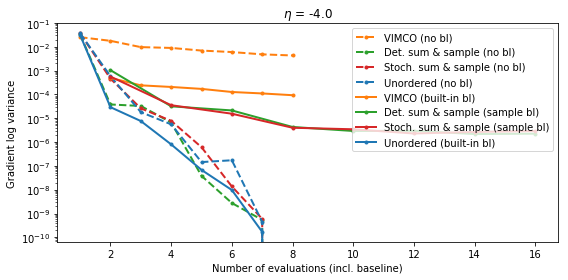

In [17]:
mixed_grad_array_all_bak = mixed_grad_array_all

def plot_results(estimators, mixed_grad_array_all, phi0, ylim=None, inc_baseline=False):

    mixed_grad_means = mixed_grad_array_all.mean(-1).numpy()
    mixed_grad_stds = mixed_grad_array_all.std(-1).numpy()
    
    mixed_grad_stds[mixed_grad_stds < 1e-8]  = 0

    fig = plt.figure(figsize=(8, 4))
    xrng = np.arange(mixed_grad_stds.shape[1]) + 1
    estimator_names = []
    for grad_arr, (est, name, n_ev, plot_kwargs) in zip(mixed_grad_stds, estimators):
        plt.plot(n_ev if inc_baseline else xrng, grad_arr ** 2, **plot_kwargs, lw='2')
        estimator_names.append(name)

    incl_text = "incl" if inc_baseline else "excl"
    plt.xlabel(f'Number of evaluations ({incl_text}. baseline)')
    plt.ylabel('Gradient log variance')
    if ylim is not None:
        plt.ylim(ylim)
    eta = phi0.detach().numpy()[0]
    plt.title('$\eta$ = {}'.format(eta))
    if ylim is None:
        plt.legend(estimator_names)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # fig.savefig("plots/bernoulli_toy_eta{}_{}.pdf".format(int(eta), "inc" if inc_baseline else "exc"), format='pdf')

inc_baseline=True
plot_results(estimators, mixed_grad_array_all, phi0, ylim=None, inc_baseline=inc_baseline)
plot_results(estimators_hard, mixed_grad_array_all_hard, phi0_hard, ylim=None, inc_baseline=inc_baseline)